# Get VGG dataset

In [1]:
!ls /kaggle/input/

exption-w  vgg2subset


In [2]:
train_dir = '/kaggle/input/vgg2subset/dataset/train'
test_dir = '/kaggle/input/vgg2subset/dataset/test'
val_dir = '/kaggle/input/vgg2subset/dataset/val'

# Import important libraries

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, Model
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from itertools import cycle
import math
import pandas as pd

# Preprocessing functions:

In [4]:
# Set parameters
IMG_HEIGHT = 224  # DenseNet121 default input size
IMG_WIDTH = 224
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE

# Get number of classes
NUM_CLASSES = len(os.listdir(train_dir))
print(f"Number of classes: {NUM_CLASSES}")

Number of classes: 80


In [5]:
def process_path(file_path, label):
    # Read and preprocess image
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.cast(img, tf.float32)
    # Preprocess for DenseNet
    img = tf.keras.applications.densenet.preprocess_input(img)
    return img, label

def augment(image, label):
    # Data augmentation
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # Random brightness, contrast, and saturation
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_saturation(image, 0.5, 2.0)
    image = tf.image.random_contrast(image, 0.5, 2.0)

    return image, label

def create_dataset(directory, is_training=False):
    class_names = sorted(os.listdir(directory))
    class_dict = {name: idx for idx, name in enumerate(class_names)}

    image_paths = []
    labels = []

    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        for img_name in os.listdir(class_path):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(class_path, img_name)
                image_paths.append(img_path)
                labels.append(class_dict[class_name])

    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    if is_training:
        ds = ds.shuffle(len(image_paths), reshuffle_each_iteration=True)

    ds = ds.map(process_path, num_parallel_calls=AUTO)

    if is_training:
        ds = ds.map(augment, num_parallel_calls=AUTO)

    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(AUTO)

    return ds, len(image_paths)

# Apply preprocessing functions on the dataset

In [6]:
# Create datasets
print("Creating datasets...")
train_ds, train_size = create_dataset(train_dir, is_training=True)
val_ds, val_size = create_dataset(val_dir, is_training=False)
test_ds, test_size = create_dataset(test_dir, is_training=False)

print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Test samples: {test_size}")

Creating datasets...
Training samples: 23223
Validation samples: 2875
Test samples: 2973


# Creating the model

## Defining the model function

In [7]:
def create_model():
    # Load pre-trained DenseNet121
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )

    # Freeze the base model
    base_model.trainable = False

    # Create model
    inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = base_model(inputs, training=False)

    # Add custom layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)

    # Dense layers
    x = layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    # Output layer
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    return Model(inputs, outputs)

# Create model
print("Creating model...")
model = create_model()

# Print model summary
model.summary()

# First phase compilation
initial_learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(
    learning_rate=initial_learning_rate,
    weight_decay=1e-5
)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_densenet_model.keras',
        save_best_only=True,
        monitor='val_accuracy'
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    )
]

Creating model...
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 80)             │        41,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,663,184 (33.05 MB)

 Trainable params: 1,620,560 (6.18 MB)

 Non-trainable params: 7,042,624 (26.87 MB)

## Train the model with 10 epochs

In [8]:
# First training phase
print("Phase 1: Training top layers...")
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)

Phase 1: Training top layers...
Epoch 1/10


I0000 00:00:1734548161.111364      92 service.cc:145] XLA service 0x7c739408bb30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734548161.111433      92 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734548161.111440      92 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/726 ━━━━━━━━━━━━━━━━━━━━ 6:16:03 31s/step - accuracy: 0.0000e+00 - loss: 5.2789

I0000 00:00:1734548179.374400      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


726/726 ━━━━━━━━━━━━━━━━━━━━ 151s 166ms/step - accuracy: 0.1151 - loss: 4.1661 - val_accuracy: 0.3078 - val_loss: 2.8662 - learning_rate: 0.0010
Epoch 2/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 66s 90ms/step - accuracy: 0.3035 - loss: 2.9851 - val_accuracy: 0.3666 - val_loss: 2.6552 - learning_rate: 0.0010
Epoch 3/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 65s 90ms/step - accuracy: 0.3504 - loss: 2.7866 - val_accuracy: 0.3917 - val_loss: 2.6192 - learning_rate: 0.0010
Epoch 4/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 64s 89ms/step - accuracy: 0.3802 - loss: 2.6696 - val_accuracy: 0.4129 - val_loss: 2.5752 - learning_rate: 0.0010
Epoch 5/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 65s 89ms/step - accuracy: 0.4020 - loss: 2.6130 - val_accuracy: 0.4157 - val_loss: 2.5099 - learning_rate: 0.0010
Epoch 6/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 65s 89ms/step - accuracy: 0.4178 - loss: 2.5608 - val_accuracy: 0.4198 - val_loss: 2.5577 - learning_rate: 0.0010
Epoch 7/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 65s 90ms/step - accuracy: 0.4195 - loss: 2.54

## Finetune it with 15 epochs

In [9]:
# Fine-tuning phase
print("Phase 2: Fine-tuning DenseNet layers...")
# Unfreeze the base model
base_model = model.layers[1]
base_model.trainable = True

# Freeze first 100 layers of DenseNet
for layer in base_model.layers[:100]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=1e-5,
        weight_decay=1e-6
    ),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Second training phase
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks
)

Phase 2: Fine-tuning DenseNet layers...
Epoch 1/15
726/726 ━━━━━━━━━━━━━━━━━━━━ 323s 292ms/step - accuracy: 0.4110 - loss: 2.7337 - val_accuracy: 0.4814 - val_loss: 2.4170 - learning_rate: 1.0000e-05
Epoch 2/15
726/726 ━━━━━━━━━━━━━━━━━━━━ 142s 195ms/step - accuracy: 0.5053 - loss: 2.3222 - val_accuracy: 0.5249 - val_loss: 2.2477 - learning_rate: 1.0000e-05
Epoch 3/15
726/726 ━━━━━━━━━━━━━━━━━━━━ 141s 194ms/step - accuracy: 0.5537 - loss: 2.1434 - val_accuracy: 0.5569 - val_loss: 2.1143 - learning_rate: 1.0000e-05
Epoch 4/15
726/726 ━━━━━━━━━━━━━━━━━━━━ 141s 194ms/step - accuracy: 0.5820 - loss: 2.0249 - val_accuracy: 0.5927 - val_loss: 2.0115 - learning_rate: 1.0000e-05
Epoch 5/15
726/726 ━━━━━━━━━━━━━━━━━━━━ 142s 195ms/step - accuracy: 0.6152 - loss: 1.9045 - val_accuracy: 0.6226 - val_loss: 1.9077 - learning_rate: 1.0000e-05
Epoch 6/15
726/726 ━━━━━━━━━━━━━━━━━━━━ 141s 195ms/step - accuracy: 0.6358 - loss: 1.8379 - val_accuracy: 0.6459 - val_loss: 1.8377 - learning_rate: 1.0000e-05


# Evaluate the model

## Acuuracy of the test dataset (Unseen data)

In [10]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"\nFinal Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")

93/93 ━━━━━━━━━━━━━━━━━━━━ 19s 208ms/step - accuracy: 0.7380 - loss: 1.4925

Final Test Loss: 1.3886
Final Test Accuracy: 0.7568


## Get class names and predictions

In [11]:
# Get class names
class_names = sorted(os.listdir(train_dir))
def get_predictions(model, test_ds):
    y_pred_probs = []
    y_true = []
    
    print("Getting predictions...")
    for images, labels in test_ds:
        pred = model.predict(images, verbose=0)
        y_pred_probs.extend(pred)
        y_true.extend(labels)
    
    return np.array(y_pred_probs), np.array(y_true)

# Get predictions
y_pred_probs, y_true = get_predictions(model, test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

Getting predictions...


## Acuuracy and loss in each epoch

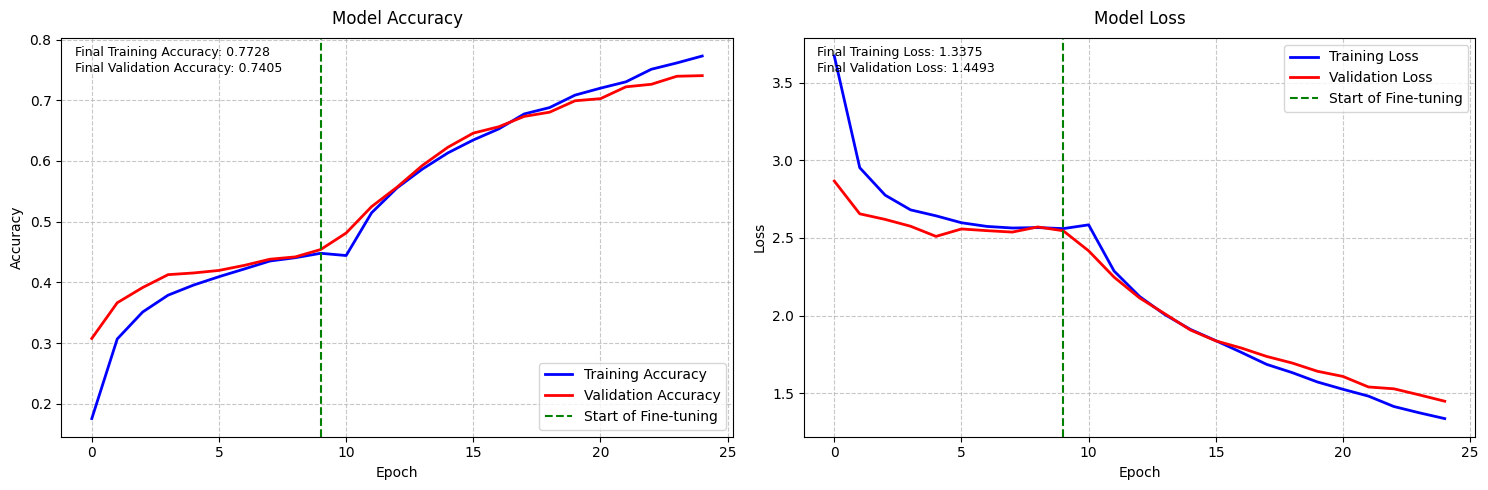


Training Metrics for Each Epoch:

Phase 1 (Initial Training):
----------------------------
Epoch  1/25
Training Accuracy: 0.1759
Validation Accuracy: 0.3078
Training Loss: 3.6706
Validation Loss: 2.8662
----------------------------------------
Epoch  2/25
Training Accuracy: 0.3070
Validation Accuracy: 0.3666
Training Loss: 2.9520
Validation Loss: 2.6552
----------------------------------------
Epoch  3/25
Training Accuracy: 0.3514
Validation Accuracy: 0.3917
Training Loss: 2.7752
Validation Loss: 2.6192
----------------------------------------
Epoch  4/25
Training Accuracy: 0.3791
Validation Accuracy: 0.4129
Training Loss: 2.6805
Validation Loss: 2.5752
----------------------------------------
Epoch  5/25
Training Accuracy: 0.3957
Validation Accuracy: 0.4157
Training Loss: 2.6422
Validation Loss: 2.5099
----------------------------------------
Epoch  6/25
Training Accuracy: 0.4095
Validation Accuracy: 0.4198
Training Loss: 2.5977
Validation Loss: 2.5577
-------------------------------

In [12]:
def plot_training_metrics(history1, history2):
    # Combine histories from both phases
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']
    
    # Create figure with two subplots side by side
    plt.figure(figsize=(15, 5))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(acc, 'b-', label='Training Accuracy', linewidth=2)
    plt.plot(val_acc, 'r-', label='Validation Accuracy', linewidth=2)
    
    # Add vertical line to separate phases
    plt.axvline(x=len(history1.history['accuracy'])-1, color='g', linestyle='--', label='Start of Fine-tuning')
    
    plt.title('Model Accuracy', fontsize=12, pad=10)
    plt.xlabel('Epoch', fontsize=10)
    plt.ylabel('Accuracy', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='lower right', fontsize=10)
    
    # Add text annotations for final values
    plt.text(0.02, 0.98, f'Final Training Accuracy: {acc[-1]:.4f}', 
             transform=plt.gca().transAxes, verticalalignment='top', fontsize=9)
    plt.text(0.02, 0.94, f'Final Validation Accuracy: {val_acc[-1]:.4f}', 
             transform=plt.gca().transAxes, verticalalignment='top', fontsize=9)
    
    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, 'b-', label='Training Loss', linewidth=2)
    plt.plot(val_loss, 'r-', label='Validation Loss', linewidth=2)
    
    # Add vertical line to separate phases
    plt.axvline(x=len(history1.history['loss'])-1, color='g', linestyle='--', label='Start of Fine-tuning')
    
    plt.title('Model Loss', fontsize=12, pad=10)
    plt.xlabel('Epoch', fontsize=10)
    plt.ylabel('Loss', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper right', fontsize=10)
    
    # Add text annotations for final values
    plt.text(0.02, 0.98, f'Final Training Loss: {loss[-1]:.4f}', 
             transform=plt.gca().transAxes, verticalalignment='top', fontsize=9)
    plt.text(0.02, 0.94, f'Final Validation Loss: {val_loss[-1]:.4f}', 
             transform=plt.gca().transAxes, verticalalignment='top', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print the values for each epoch
    print("\nTraining Metrics for Each Epoch:")
    print("=================================")
    total_epochs = len(acc)
    
    print("\nPhase 1 (Initial Training):")
    print("----------------------------")
    for epoch in range(len(history1.history['accuracy'])):
        print(f"Epoch {epoch+1:2d}/{total_epochs}")
        print(f"Training Accuracy: {history1.history['accuracy'][epoch]:.4f}")
        print(f"Validation Accuracy: {history1.history['val_accuracy'][epoch]:.4f}")
        print(f"Training Loss: {history1.history['loss'][epoch]:.4f}")
        print(f"Validation Loss: {history1.history['val_loss'][epoch]:.4f}")
        print("-" * 40)
    
    print("\nPhase 2 (Fine-tuning):")
    print("----------------------")
    for epoch in range(len(history2.history['accuracy'])):
        current_epoch = epoch + len(history1.history['accuracy']) + 1
        print(f"Epoch {current_epoch:2d}/{total_epochs}")
        print(f"Training Accuracy: {history2.history['accuracy'][epoch]:.4f}")
        print(f"Validation Accuracy: {history2.history['val_accuracy'][epoch]:.4f}")
        print(f"Training Loss: {history2.history['loss'][epoch]:.4f}")
        print(f"Validation Loss: {history2.history['val_loss'][epoch]:.4f}")
        print("-" * 40)

# After training, call the function:
plot_training_metrics(history1, history2)

## Precision, Recall, and F1-Score matrix

In [13]:
def calculate_average_metrics(y_true, y_pred, class_names):
    # Get classification report as dict
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    
    # Create DataFrame for average metrics
    avg_metrics = pd.DataFrame({
        'Precision': [report['macro avg']['precision']],
        'Recall': [report['macro avg']['recall']],
        'F1-Score': [report['macro avg']['f1-score']]
    }, index=['Macro Average'])
    
    # Add weighted averages
    avg_metrics.loc['Weighted Average'] = [
        report['weighted avg']['precision'],
        report['weighted avg']['recall'],
        report['weighted avg']['f1-score']
    ]
    
    return avg_metrics

# Calculate and display average metrics
avg_metrics = calculate_average_metrics(y_true, y_pred, class_names)
print("Average Metrics:")
print("===============")
print(avg_metrics)

Average Metrics:
                  Precision    Recall  F1-Score
Macro Average      0.762601  0.734106  0.734552
Weighted Average   0.772903  0.756811  0.753750


## ROC Curve


AUC Scores Summary:

Micro-average AUC: 0.9924
Macro-average AUC: 0.9911

Per-Class AUC Scores:
-------------------
n000421: 0.9839
n000422: 0.9859
n000423: 0.9931
n000424: 0.9820
n000425: 0.9892
n000426: 0.9912
n000427: 0.9989
n000428: 0.9970
n000429: 0.9919
n000430: 0.9968
n000431: 0.9944
n000432: 0.9960
n000433: 0.9921
n000434: 0.9993
n000435: 0.9978
n000436: 0.9908
n000437: 0.9487
n000438: 0.9891
n000439: 0.9519
n000440: 0.9700
n000441: 0.9969
n000442: 0.9950
n000443: 0.9923
n000444: 0.9801
n000445: 0.9872
n000446: 0.9871
n000447: 0.9859
n000448: 0.9894
n000449: 0.9984
n000450: 0.9867
n000451: 0.9875
n000453: 0.9884
n000454: 0.9864
n000455: 0.9967
n000456: 0.9871
n000457: 0.9785
n000458: 0.9815
n000459: 0.9998
n000460: 0.9980
n000461: 0.9960
n000462: 0.9926
n000463: 0.9975
n000464: 0.9980
n000465: 0.9930
n000466: 0.9998
n000467: 0.9981
n000468: 0.9981
n000469: 0.9998
n000470: 1.0000
n000471: 0.9990
n000472: 0.9893
n000473: 0.9959
n000474: 0.9967
n000475: 0.9989
n000476: 0.9974
n00

/tmp/ipykernel_23/1083410380.py:63: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


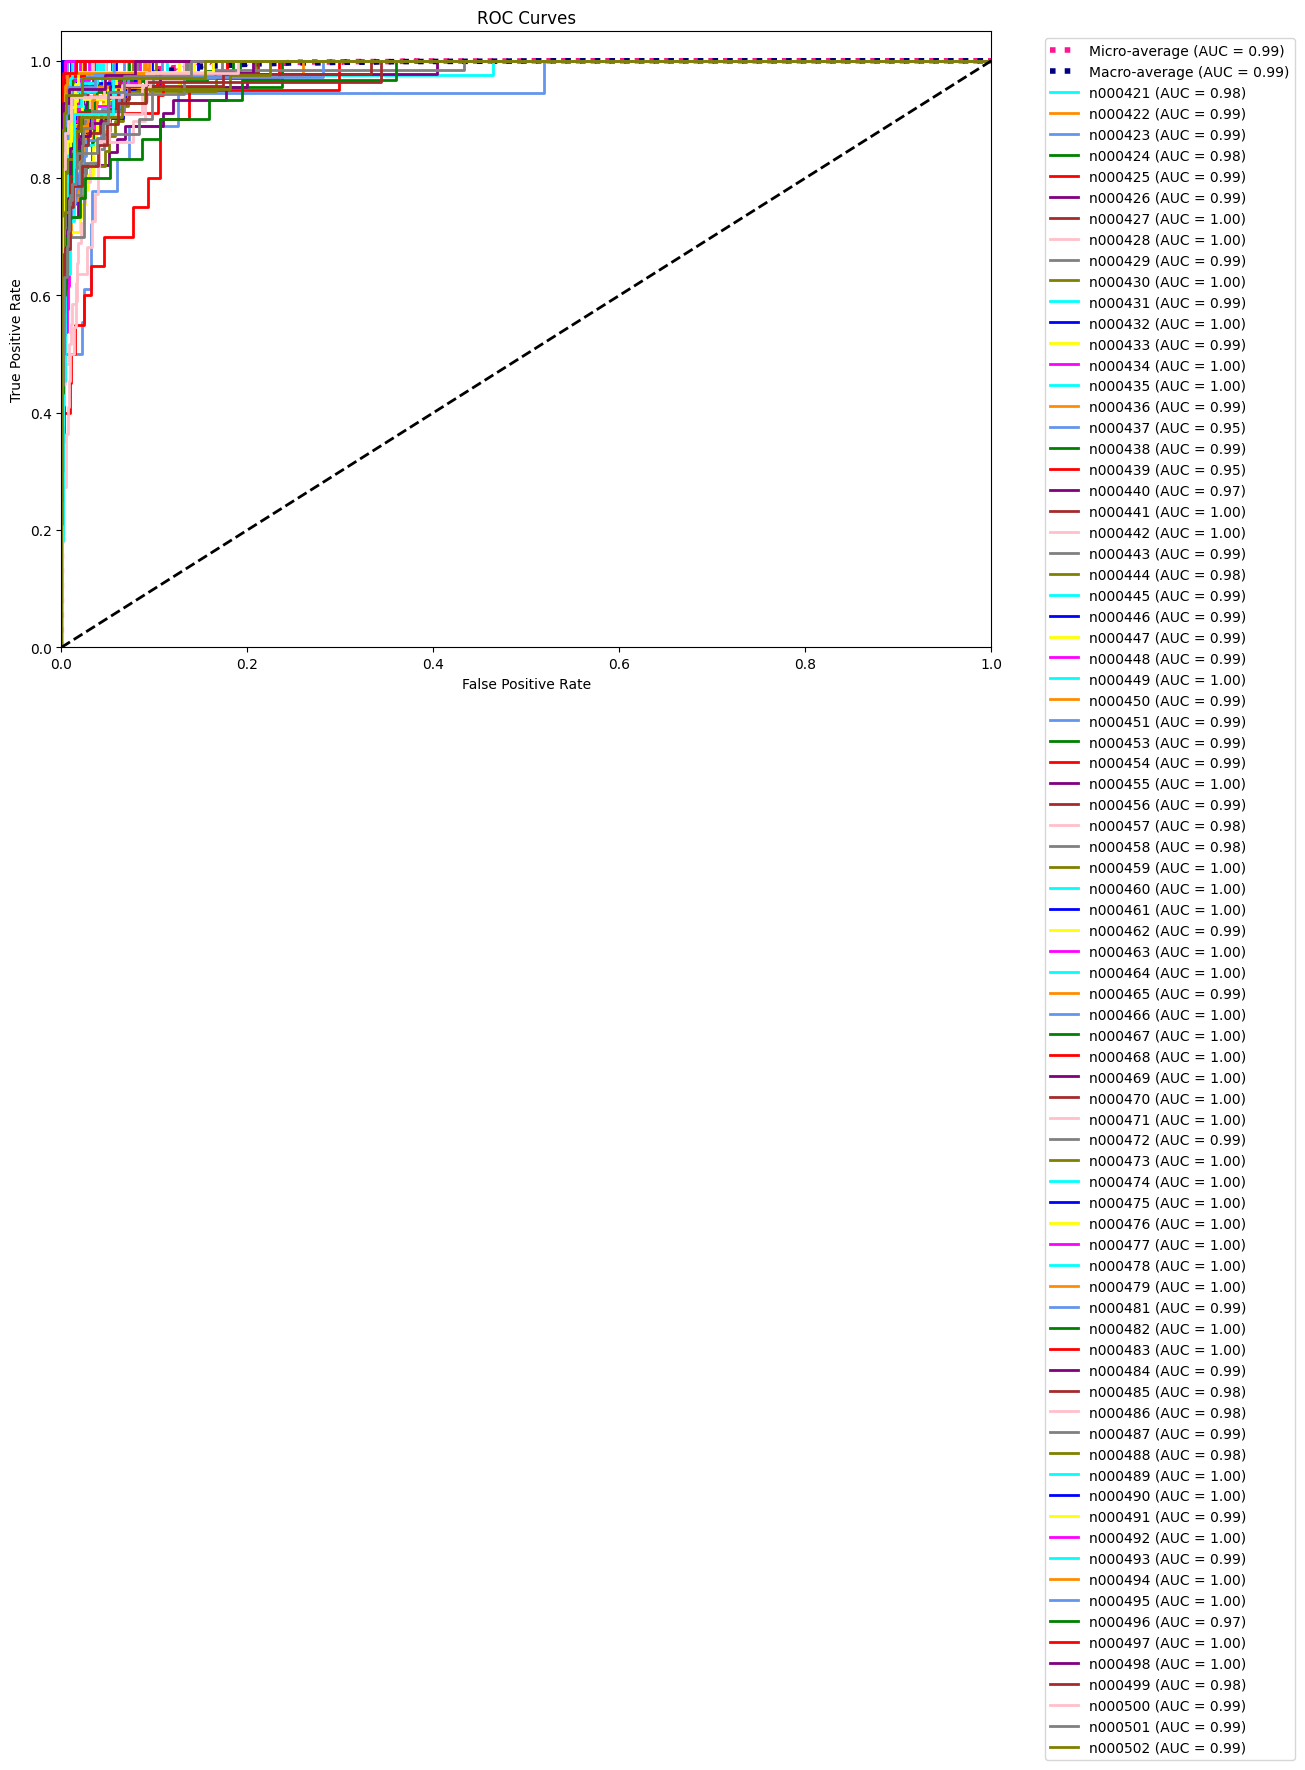

In [14]:
def plot_roc_curves(y_true, y_pred_probs, class_names):
    # Convert to one-hot encoding
    y_true_binary = tf.keras.utils.to_categorical(y_true, num_classes=len(class_names))
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binary.ravel(), y_pred_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Compute macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(class_names)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(class_names)
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Print AUC scores
    print("\nAUC Scores Summary:")
    print("==================")
    print(f"\nMicro-average AUC: {roc_auc['micro']:.4f}")
    print(f"Macro-average AUC: {roc_auc['macro']:.4f}")
    print("\nPer-Class AUC Scores:")
    print("-------------------")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {roc_auc[i]:.4f}")
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    
    # Plot averages
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)
    plt.plot(fpr["macro"], tpr["macro"],
             label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})',
             color='navy', linestyle=':', linewidth=4)
    
    # Plot individual classes
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple',
                   'brown', 'pink', 'gray', 'olive', 'cyan', 'blue', 'yellow', 'magenta'])
    for i, (color, class_name) in enumerate(zip(colors, class_names)):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'{class_name} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # Create and return DataFrame with AUC scores
    auc_scores = {
        'Class': class_names + ['Micro-average', 'Macro-average'],
        'AUC': [roc_auc[i] for i in range(len(class_names))] + [roc_auc['micro'], roc_auc['macro']]
    }
    auc_df = pd.DataFrame(auc_scores)
    
    return auc_df

# Plot ROC curves and get AUC scores
auc_scores = plot_roc_curves(y_true, y_pred_probs, class_names)

# Confusion matrix for each class

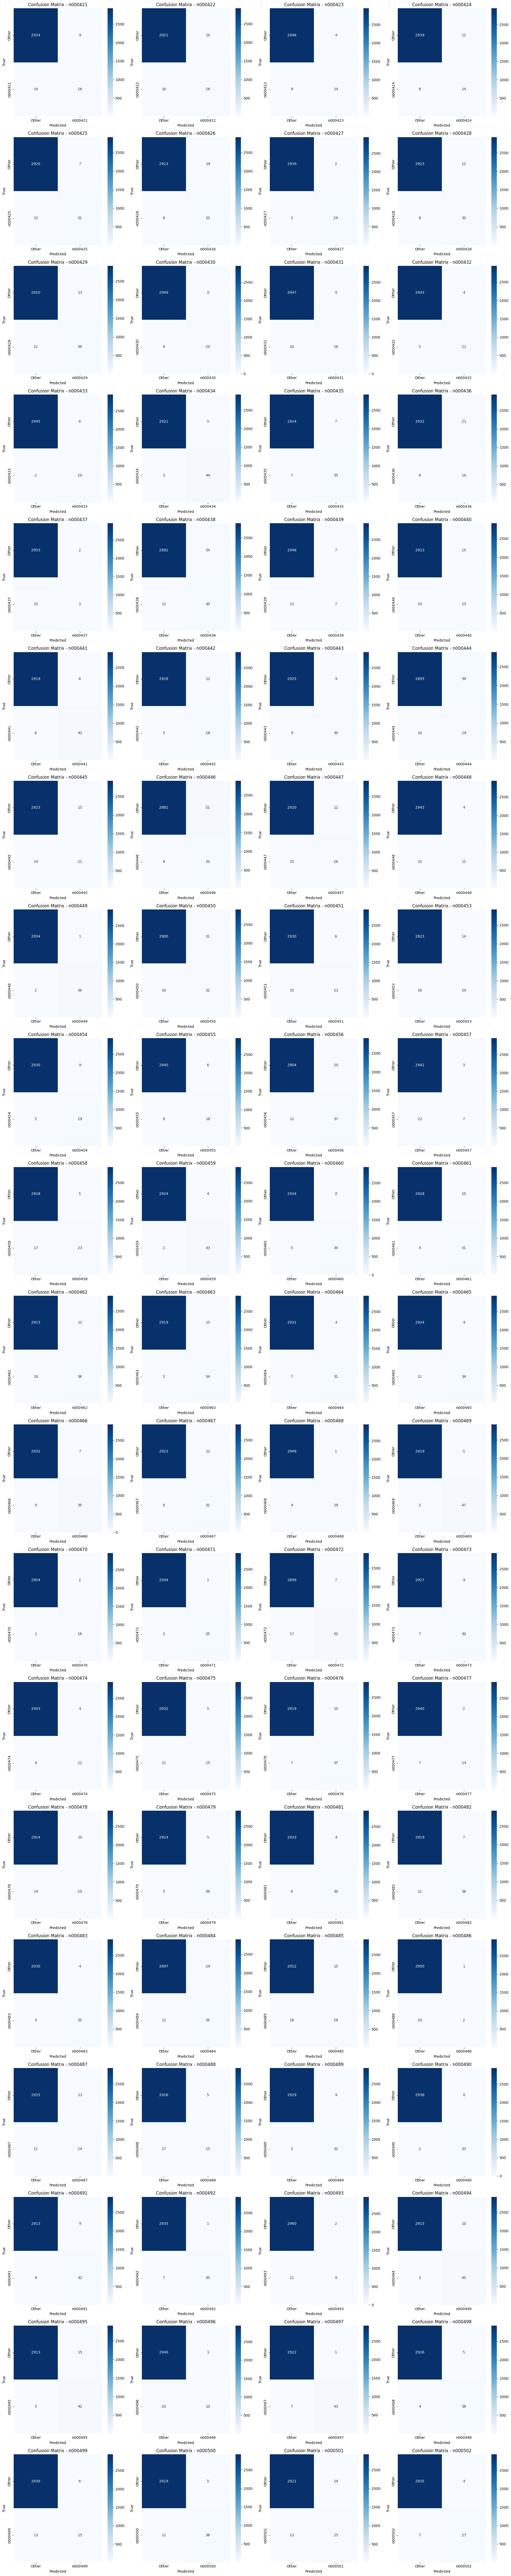

In [15]:
def plot_per_class_confusion_matrices(y_true, y_pred, class_names):
    # Calculate number of rows and columns for subplot grid
    n_classes = len(class_names)
    n_cols = 4  # You can adjust this
    n_rows = math.ceil(n_classes / n_cols)
    
    # Create figure
    plt.figure(figsize=(20, 5 * n_rows))
    
    for idx, class_name in enumerate(class_names):
        # Create binary labels for this class
        y_true_binary = (y_true == idx).astype(int)
        y_pred_binary = (y_pred == idx).astype(int)
        
        # Calculate confusion matrix
        cm = confusion_matrix(y_true_binary, y_pred_binary)
        
        # Create subplot
        plt.subplot(n_rows, n_cols, idx + 1)
        
        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Other', class_name],
                   yticklabels=['Other', class_name])
        
        plt.title(f'Confusion Matrix - {class_name}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
    
    plt.tight_layout()
    plt.show()

plot_per_class_confusion_matrices(y_true, y_pred, class_names)

## Confusion matrix of all classes 

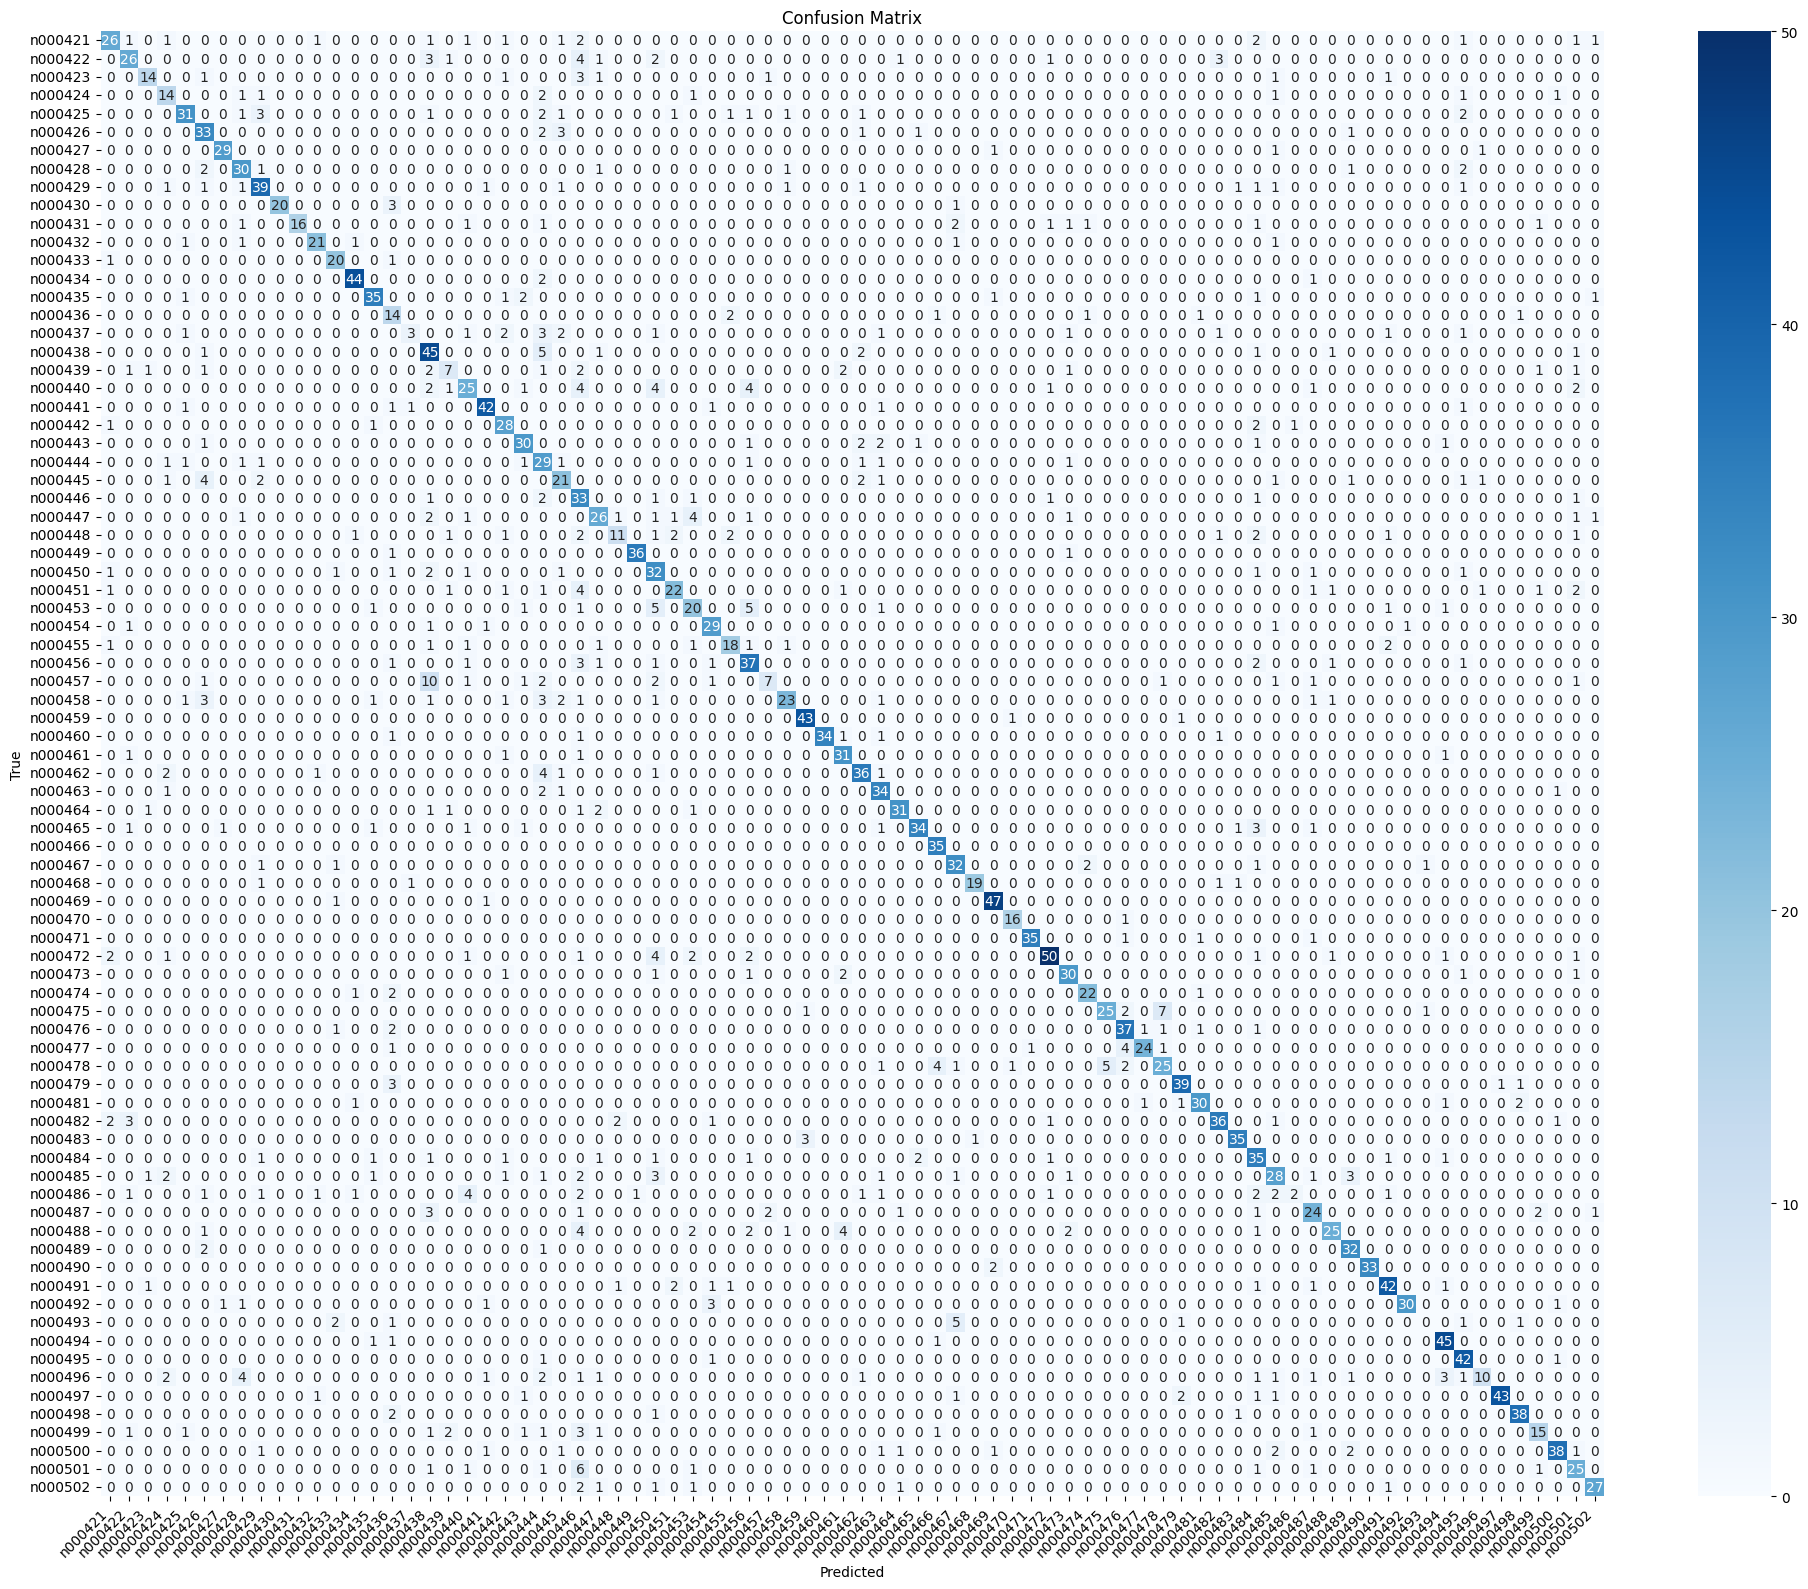

In [16]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(20, 16))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    return cm

# Plot confusion matrix
cm = plot_confusion_matrix(y_true, y_pred, class_names)